# Classification CNN Animals-10

Task: load the Animals-10, write a Convolutional Neural Network to perform classification over most frequent face classes, test the network and plot the results for each class.

![Animals-10](https://storage.googleapis.com/kaggle-datasets-images/59760/115796/95649e825d9344084af2a24012c4d072/dataset-cover.jpg?t=2018-10-05-08-07-40)

## Importing libraries

In [1]:
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.1/823.1 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 29.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 92.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 45.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [2]:
import os
import gc

# Matplotlib for plotting, numpy for math operations
from matplotlib import pyplot as plt
import numpy as np

# PyTorch Lightning ⚡ to define our neural network
import torch
import torch.nn as nn
from torch.nn import functional as F
import pytorch_lightning as pl
from pytorch_lightning import LightningModule, Trainer

# Dataloader and torchvision to define our input dataset
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms, datasets

# Torchmetrics to monitor metrics (classification accuracy)
from torchmetrics.functional.classification.accuracy import accuracy


## Importing the Dataset

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/My\ Drive

/content/drive/My Drive


In [ ]:
!unzip animals-tiny.zip

Archive:  animals-tiny.zip
replace __MACOSX/._archive? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

## Defining parameters and hyperparameters


*   **Learning rate**: learning speed of the network
*   **Batch size**: visible samples per iteration
*   **Dataset size**: total number of samples
*   **Train size**: training samples
*   **Val size**: validation samples
*   **Input width**: width of the input image
*   **Input height**: height of the input image
*   **Input channels**: number of channels of the input image
*   **Mean**: dataset mean
*   **Std**: dataset standard variance
*   **Hidden dim**: neurons in the hidden layer
*   **Num classes**: classes to classify





For small dataset

In [5]:
mean = [0.5139, 0.4969, 0.4045]
std = [0.2107, 0.2080, 0.2132]

Substitute 'archive/raw-img' with 'raw-img' to work on small dataset

In [6]:
manual_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

Substitute 'archive/raw-img' with 'raw-img' to work on small dataset

In [7]:
dataset = datasets.ImageFolder(root='archive/raw-img', transform=manual_transform)
print(f"Dataset size: {len(dataset)}")

Dataset size: 1000


In [8]:
learning_rate = 0.0001
batch_size = 32 #depending on the gpu in use

dataset_size = len(dataset)
train_size = int (0.7 * dataset_size)
val_size = int (0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

print(f"Train size: {train_size}")
print(f"Val size: {val_size}")
print(f"Test size: {test_size}")

input_width = 128
input_height = 128
input_channels = 3  #using RGB

hidden_dim = 64
num_classes = 10

assert train_size + val_size + test_size == dataset_size, "The sum of the train and validation sets must be equal the whole dataset size"
assert input_width == input_height, "The input width should be the same as the input height"

Train size: 700
Val size: 150
Test size: 150


Loading the dataset

In [9]:
loader = DataLoader(dataset, batch_size, shuffle=False, num_workers=0)

## Defining the DataModule

In [10]:
class MyCustomDataModule(pl.LightningDataModule):
    def __init__(self, data_dir: str = "./"):
        super().__init__()

    def prepare_data(self):
        self.dataset = dataset

    def setup(self, stage = None):
        self.dataset_train, self.dataset_val, self.dataset_test = random_split(self.dataset, [train_size, val_size, test_size])

    def train_dataloader(self):
        return DataLoader(self.dataset_train, batch_size=batch_size)

    def val_dataloader(self):
        return DataLoader(self.dataset_val, batch_size=batch_size)

    def test_dataloader(self):
        return DataLoader(self.dataset_test, batch_size=batch_size)

## Defining the Convolutional Neural Network


In [11]:
class MyCustomCNNModel(LightningModule):
    def __init__(self, num_classes=10, dropout_rate=0.25):
        super().__init__()

        self.save_hyperparameters()

        self.train_preds, self.train_targets = [], []
        self.val_preds, self.val_targets = [], []
        self.test_preds, self.test_targets = [], []

        # CNN layers
        self.conv_block = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
        )

        # Compute flattened feature size after conv layers
        self.feature_size = 64 * (128 // 4) * (128 // 4)

        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.feature_size, 256),
            nn.ReLU(),
            nn.Dropout(self.hparams.dropout_rate),
            nn.Linear(256, self.hparams.num_classes),
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.classifier(x)
        return x

    def _shared_step(self, batch, stage: str):
        inputs, targets = batch
        logits = self(inputs)
        loss = F.cross_entropy(logits, targets)
        preds = torch.argmax(logits, dim=1)
        acc = accuracy(preds, targets, task='multiclass', num_classes=self.hparams.num_classes)

        # Log metrics
        self.log(f"{stage}_loss", loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log(f"{stage}_acc", acc, prog_bar=True, on_step=False, on_epoch=True)

        return loss, preds, targets

    def training_step(self, batch, batch_idx):
        loss, preds, targets = self._shared_step(batch, "train")
        self.train_preds.append(preds.detach().cpu())
        self.train_targets.append(targets.detach().cpu())
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, targets = self._shared_step(batch, "val")
        self.val_preds.append(preds.detach().cpu())
        self.val_targets.append(targets.detach().cpu())
        return loss

    def test_step(self, batch, batch_idx):
        loss, preds, targets = self._shared_step(batch, "test")
        self.test_preds.append(preds.detach().cpu())
        self.test_targets.append(targets.detach().cpu())
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-4)



## Training

In [12]:
model = MyCustomCNNModel()
datamodule = MyCustomDataModule()

trainer = Trainer(
    max_epochs= 100
)

trainer.fit(model, datamodule)

INFO:pytorch_lightning.utilities.rank_zero:Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | conv_block | Sequential | 19.4 K | train
1 | classifier | Sequential | 16.8 M | train
--------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.198    Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


In [13]:
trainer.fit(model, datamodule)
gc.collect()

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/My Drive/lightning_logs/version_29/checkpoints exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name       | Type       | Params | Mode 
--------------------------------------------------
0 | conv_block | Sequential | 19.4 K | train
1 | classifier | Sequential | 16.8 M | train
--------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.198    Total estimated model params size (MB)
14        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=100` reached.


532

## Testing

In [14]:
trainer.test(model, datamodule=datamodule)

Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.8399999737739563     │
│         test_loss         │    0.8931403756141663     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.8931403756141663, 'test_acc': 0.8399999737739563}]

## Showing results

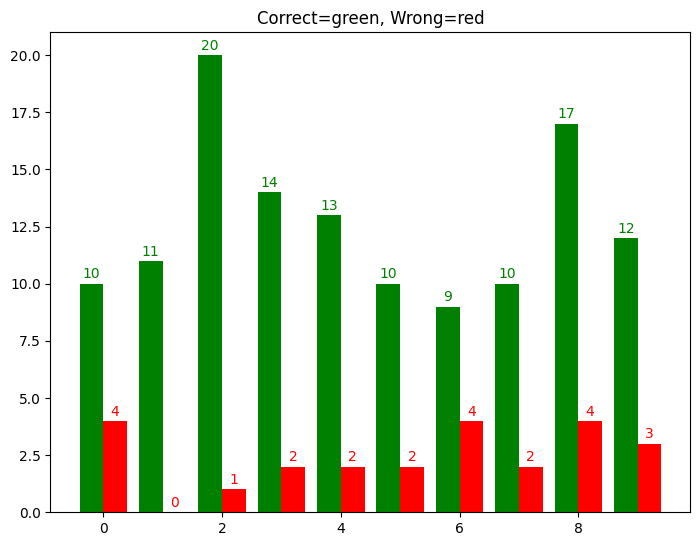

In [21]:
correct = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
wrong = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

for i, (batch_gt, batch_pred) in enumerate(zip(model.test_targets, model.test_preds)):
  for gt, pred in zip(batch_gt, batch_pred):
    if gt == pred:
      correct[gt] += 1
    else:
      wrong[gt] += 1

class_labels = np.array([0., 1., 2., 3., 4., 5., 6., 7., 8., 9.])

fig = plt.figure()
ax = fig.add_axes([0,0,1,1], title='Correct=green, Wrong=red')

bar_width = 0.4
x_correct = class_labels - bar_width/2
x_wrong = class_labels + bar_width/2

bars_correct = ax.bar(x_correct, correct, width=bar_width, color='g')
bars_wrong = ax.bar(x_wrong, wrong, width=bar_width, color='r')

# Adding numbers
for rect in bars_correct:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.1, str(int(height)), ha='center', va='bottom', color='green')

for rect in bars_wrong:
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.1, str(int(height)), ha='center', va='bottom', color='red')

plt.show()


If everything is correct, you should obtain a plot like the one below.

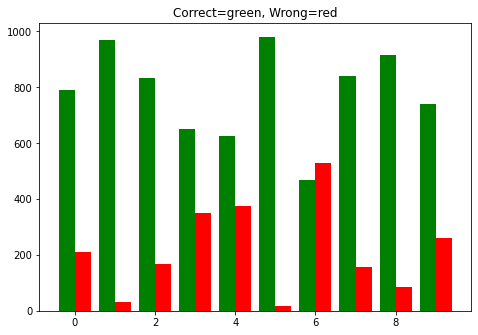